In [7]:
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [8]:
m1="CIC-IDS-2017/Monday-WorkingHours.pcap_ISCX.csv"
t1="CIC-IDS-2017/Tuesday-WorkingHours.pcap_ISCX.csv"
w1="CIC-IDS-2017/Wednesday-workingHours.pcap_ISCX.csv"
th1="CIC-IDS-2017/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv"
th2="CIC-IDS-2017/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv"
f1="CIC-IDS-2017/Friday-WorkingHours-Morning.pcap_ISCX.csv"
f2="CIC-IDS-2017/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv"
f3="CIC-IDS-2017/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv"

dm1 = pd.read_csv(m1)
dt1 = pd.read_csv(t1)
dw1 = pd.read_csv(w1)
dth1 = pd.read_csv(th1)
dth2 = pd.read_csv(th2)
df1 = pd.read_csv(f1)
df2 = pd.read_csv(f2)
df3 = pd.read_csv(f3)

In [9]:
df = pd.concat([dm1,dt1,dw1,dth1,dth2,df1, df2, df3], axis=0)

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.dropna()

In [10]:
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])

class_names=le.classes_

In [11]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [51]:

params = {
    "objective": "multi:softmax",   # Use softmax for multiclass classification
    "num_class": len(class_names), # Specify the number of classes
    #"booster": "gbtree",            # Use tree-based models
    "learning_rate": 0.2,
    "tree_method": "hist",      # GPU acceleration
    "gpu_id": 0,
    'eval_metric': 'logloss'
}

In [52]:
log_model = xgb.train(params, dtrain, num_boost_round=100)

In [53]:
y_pred = log_model.predict(dtest)

Precision: 0.9989
Recall: 0.9990
F1 Score: 0.9989


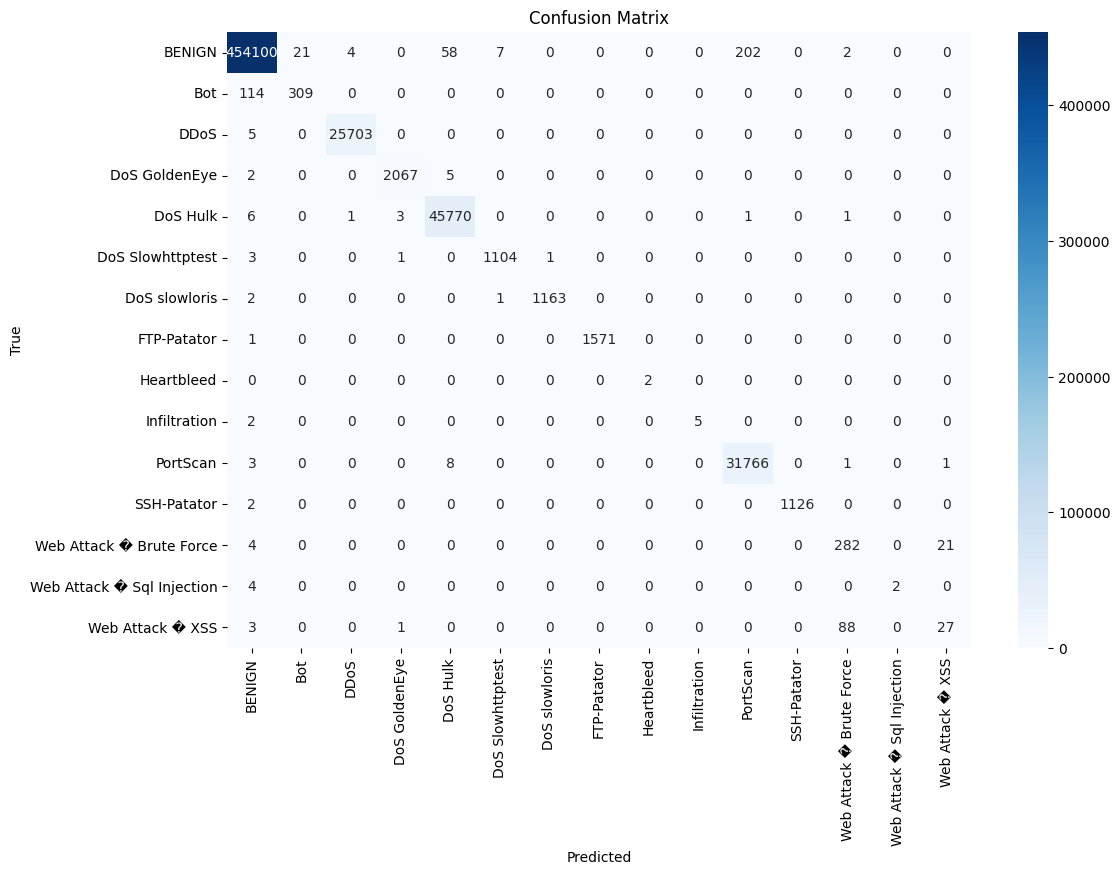


Classification Report:
                             precision    recall  f1-score   support

                    BENIGN   0.999668  0.999353  0.999510    454394
                       Bot   0.936364  0.730496  0.820717       423
                      DDoS   0.999806  0.999806  0.999806     25708
             DoS GoldenEye   0.997587  0.996625  0.997106      2074
                  DoS Hulk   0.998451  0.999738  0.999094     45782
          DoS Slowhttptest   0.992806  0.995491  0.994147      1109
             DoS slowloris   0.999141  0.997427  0.998283      1166
               FTP-Patator   1.000000  0.999364  0.999682      1572
                Heartbleed   1.000000  1.000000  1.000000         2
              Infiltration   1.000000  0.714286  0.833333         7
                  PortScan   0.993650  0.999591  0.996612     31779
               SSH-Patator   1.000000  0.998227  0.999113      1128
  Web Attack � Brute Force   0.754011  0.918567  0.828194       307
Web Attack � Sql Injec

In [54]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Precision, Recall, F1 Score
precision = precision_score(y_test, y_pred, average='weighted')  # Use 'weighted' for imbalanced datasets
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plot Confusion Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred,digits=6,target_names=class_names))

In [63]:
importance = log_model.get_score(importance_type='weight')
print("Feature Importance:", importance)

importance = dict(sorted(importance.items(),key=lambda item: item[1]))
# Extracting keys and values
features = list(importance.keys())
imp = list(importance.values())

# Plotting
plt.figure(figsize=(12, 10))
plt.barh(features, imp, color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()


Feature Importance: {' Destination Port': 2134.0, ' Flow Duration': 810.0, ' Total Fwd Packets': 288.0, ' Total Backward Packets': 190.0, 'Total Length of Fwd Packets': 426.0, ' Total Length of Bwd Packets': 443.0, ' Fwd Packet Length Max': 416.0, ' Fwd Packet Length Min': 128.0, ' Fwd Packet Length Mean': 276.0, ' Fwd Packet Length Std': 254.0, 'Bwd Packet Length Max': 147.0, ' Bwd Packet Length Min': 79.0, ' Bwd Packet Length Mean': 206.0, ' Bwd Packet Length Std': 189.0, 'Flow Bytes/s': 541.0, ' Flow Packets/s': 481.0, ' Flow IAT Mean': 516.0, ' Flow IAT Std': 329.0, ' Flow IAT Max': 448.0, ' Flow IAT Min': 1745.0, 'Fwd IAT Total': 382.0, ' Fwd IAT Mean': 365.0, ' Fwd IAT Std': 286.0, ' Fwd IAT Max': 236.0, ' Fwd IAT Min': 1181.0, 'Bwd IAT Total': 78.0, ' Bwd IAT Mean': 188.0, ' Bwd IAT Std': 116.0, ' Bwd IAT Max': 82.0, ' Bwd IAT Min': 309.0, 'Fwd PSH Flags': 93.0, ' Fwd Header Length': 483.0, ' Bwd Header Length': 129.0, 'Fwd Packets/s': 660.0, ' Bwd Packets/s': 777.0, ' Min Packe